In [1]:
import os, sys
import json
import itertools
import collections
import importlib

import tqdm

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper


SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import plot_utils
import utils
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

DEVICE = utils.get_device(2)

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots", "lcmv_clustering")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Classifier tuned from MLM on PIRD antigen + TRB data
TRANSFORMER = "wukevin/tcr-bert"
# Tuned on just MLM
TRANSFORMER_MLM_ONLY = "wukevin/tcr-bert-mlm-only"

In [2]:
lcmv = dl.load_lcmv_table()
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,v_a_gene,d_a_gene,j_a_gene,v_b_gene,d_b_gene,j_b_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRAV16N,None,TRAJ5,TRBV14,None,TRBJ2-7
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRAV3D-3,None,TRAJ38,TRBV3,None,TRBJ1-1
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRAV6-7-DV9,None,TRAJ45,TRBV13-3,None,TRBJ1-1
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRAV6D-3,None,TRAJ39,TRBV17,None,TRBJ2-1
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRAV6N-7,None,TRAJ48,TRBV10,None,TRBJ1-1


In [3]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],  # Pos and mid are both positive labels
    }
)
lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


In [4]:
lcmv_sub = dl.split_arr(lcmv_dedup, 'test')
lcmv_sub.head()

,TRA,TRB,tetramer,label
15519,CAVSLGSALGRLHF,CASSLDWVSYEQYF,TetNeg,False
12676,CATDASQGGRALIF,CASSSGGSQNTLYF,TetNeg,False
11471,CAMREMDSNYQLIW,CASSLGLGTNTGQLYF,TetNeg,False
16890,CIVTDMSSNNRIFF,CASSETGTNSDYTF,TetNeg,False
2564,CAASENSGTYQRF,CGAREGFEQYF,TetMid,True


In [5]:
lcmv_labels_sub_dict = {
    row['TRB']:row['label'] for i, row in lcmv_sub.iterrows()
}
len(lcmv_labels_sub_dict), np.mean(list(lcmv_labels_sub_dict.values()))

(2443, 0.11379451494064674)

In [6]:
# Write subsetted LCMV for GLIPH input and run GLIPH in the next cell
# GLIPH on full input takes an exremely long time
with open("transformers_clustering_lcmv.txt", 'w') as sink:
    sink.write("CDR3b\tlabel\n")
    for aa, label in lcmv_labels_sub_dict.items():
        sink.write(f"{aa}\t{label}\n")

In [7]:
%%bash
# Takes about 40 minutes to run if fully parallelized
# python ../external_eval/gliph/run_gliph.py transformers_clustering_lcmv.txt -o transformers_clustering_lcmv_gliph_perf.csv -c 0.1 0.25 0.5 0.75 1 1.25 1.5 1.75 2 2.25 2.5 3 3.5 4 4.5 5 5.5 6

In [8]:
gliph_clustering_perf_df = pd.read_csv(
    "transformers_clustering_lcmv_gliph_perf.csv",
    index_col=0
)
gliph_clustering_perf_df

,perc_clustered,perc_correct,n_clusters
0.10,0.002456,1.000000,935
0.25,0.616046,0.882392,937
0.50,0.611543,0.882195,946
0.75,0.004503,0.909091,937
1.00,0.703234,0.881257,704
1.25,0.051985,0.905512,702
1.50,0.048301,0.906780,698
1.75,0.706099,0.881159,697
2.00,0.012689,0.967742,235
2.25,0.898485,0.885649,239


In [9]:
importlib.reload(model_utils)
embeddings = model_utils.get_transformer_embeddings(
    TRANSFORMER,
    list(lcmv_labels_sub_dict.keys()),
    method='mean',
    layers=[-1],
    device=2,
)
embeddings.shape

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(2443, 768)

In [10]:
lcmv_embeddings_adata = ad.AnnData(
    embeddings,
    obs=pd.DataFrame(lcmv_labels_sub_dict.items(), columns=['TRB', 'tetramer'])
)
sc.pp.pca(lcmv_embeddings_adata, n_comps=50)
sc.pp.neighbors(lcmv_embeddings_adata)
lcmv_embeddings_adata

/home/wukevin/miniconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2443 × 768
    obs: 'TRB', 'tetramer'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
importlib.reload(custom_metrics)

leiden_resolutions = np.logspace(np.log2(48), np.log2(512), 48, base=2)
bert_clustering_perf_df = pd.DataFrame(
    0,
    index=leiden_resolutions,
    columns=['perc_clustered', 'perc_correct', 'n_clusters'],
)
for res in leiden_resolutions:
    sc.tl.leiden(lcmv_embeddings_adata, resolution=res)
    # Calculate percent clustered and percent correct

    leiden_clusters = [
        list(group[1]['TRB'])
        for group in lcmv_embeddings_adata.obs.groupby(['leiden'])
    ]
    percent_clustered, percent_correct = custom_metrics.percent_and_correct_clustered(
        lcmv_labels_sub_dict, leiden_clusters
    )
    bert_clustering_perf_df.loc[res] = (percent_clustered, percent_correct, len(leiden_clusters))
bert_clustering_perf_df

,perc_clustered,perc_correct,n_clusters
48.000000,0.995907,0.892314,350
50.479401,0.987720,0.893494,371
53.086872,0.989357,0.894084,381
55.829031,0.990176,0.895825,397
58.712834,0.986083,0.895392,407
61.745597,0.979124,0.893813,431
64.935015,0.978305,0.895816,447
68.289180,0.971756,0.895535,465
71.816602,0.970937,0.895868,476
75.526229,0.961523,0.894849,499


In [12]:
np.sum(list(lcmv_labels_sub_dict.values()))

278

In [13]:
# Paired TRA/TRB keys
# This code is really weird because we need to create TRA/TRB > label mappings
# that match the unique TRBs from before
# Because of how dicts are constructed, this is guaranteed to keep the latest entry per
# TRB
lcmv_dual_sub_dict = {  # Creates a unique per-TRB entry
    row['TRB']: (row['TRA'], row['TRB'], row['label']) for i, row in lcmv_sub.iterrows()
}
# Expand out the TRA/TRB pairs
lcmv_dual_sub_dict = {(v[0], v[1]): v[2] for v in lcmv_dual_sub_dict.values()}
# Check that labels are same proportion of pos/neg
assert np.sum(list(lcmv_dual_sub_dict.values())) == np.sum(list(lcmv_labels_sub_dict.values()))
len(lcmv_dual_sub_dict), np.mean(list(lcmv_dual_sub_dict.values()))

(2443, 0.11379451494064674)

We found that clustering based on concatenated TRA + TRB embeddings (done separately) doesn't work well

In [14]:
importlib.reload(model_utils)

lcmv_dual_embeddings = model_utils.get_transformer_embeddings(
    TRANSFORMER_MLM_ONLY,
    seqs=[tra for tra, trb in lcmv_dual_sub_dict.keys()],
    seq_pair=[trb for tra, trb in lcmv_dual_sub_dict.keys()],
    layers=[-1],
    method='mean',
    device=0,
)
lcmv_dual_embeddings.shape

(2443, 768)

In [15]:
lcmv_dual_embeddings_adata = ad.AnnData(
    lcmv_dual_embeddings,
    obs=pd.DataFrame(lcmv_dual_sub_dict.items(), columns=['TRA/TRB', 'tetramer'])
)
sc.pp.pca(lcmv_dual_embeddings_adata, n_comps=50)
sc.pp.neighbors(lcmv_dual_embeddings_adata)
lcmv_dual_embeddings_adata

/home/wukevin/miniconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2443 × 768
    obs: 'TRA/TRB', 'tetramer'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
importlib.reload(custom_metrics)

bert_dual_clustering_perf_df = pd.DataFrame(
    0,
    index=leiden_resolutions,
    columns=['perc_clustered', 'perc_correct', 'n_clusters'],
)
for res in leiden_resolutions:
    sc.tl.leiden(lcmv_dual_embeddings_adata, resolution=res)
    # Calculate percent clustered and percent correct
    leiden_clusters = [
        list(group[1]['TRA/TRB'])
        for group in lcmv_dual_embeddings_adata.obs.groupby(['leiden'])
    ]  # List of tuples of str
    percent_clustered, percent_correct = custom_metrics.percent_and_correct_clustered(
        lcmv_dual_sub_dict, leiden_clusters
    )
    bert_dual_clustering_perf_df.loc[res] = (
        percent_clustered, percent_correct, len(leiden_clusters)
    )

bert_dual_clustering_perf_df

,perc_clustered,perc_correct,n_clusters
48.000000,0.990176,0.893344,379
50.479401,0.986083,0.893317,406
53.086872,0.985264,0.893644,421
55.829031,0.986083,0.894562,430
58.712834,0.976259,0.893920,458
61.745597,0.975031,0.894207,475
64.935015,0.972165,0.895158,490
68.289180,0.969300,0.896115,505
71.816602,0.963979,0.895117,523
75.526229,0.957429,0.896965,540


In [72]:
# Compute metricxs for tcrdist3

def load_tcrdist3_results(truth_fname, results_fname):
    with open(results_fname) as source:
        tcrdist3_clusterings = json.load(source)

    with open(truth_fname) as source:
        tcrdist3_truth = json.load(source)
    tcrdist3_cluster_perf = pd.DataFrame(0, index=tcrdist3_clusterings.keys(), columns=['perc_clustered', 'perc_correct', 'n_clusters'])
    for k, clustering in tcrdist3_clusterings.items():
        perc_clustered, perc_correct = custom_metrics.percent_and_correct_clustered(
            tcrdist3_truth, clustering
        )
        tcrdist3_cluster_perf.loc[k] = (perc_clustered, perc_correct, k)
    tcrdist3_cluster_perf.index = [int(i) for i in tcrdist3_cluster_perf.index]
    return tcrdist3_cluster_perf

tcrdist3_cluster_perf = load_tcrdist3_results(
    "/home/wukevin/projects/tcr/tcr-bert/external_eval/tcrdist3_aggcluster_truth.json",
    "/home/wukevin/projects/tcr/tcr-bert/external_eval/tcrdist3_aggcluster_results.json"
)
tcrdist3_cluster_perf.head()

,perc_clustered,perc_correct,n_clusters
30,0.995104,0.877744,30
70,0.990584,0.877567,70
110,0.985311,0.877294,110
150,0.978908,0.877260,150
190,0.972128,0.877567,190


In [73]:
tcrdist3_dual_cluster_perf = load_tcrdist3_results(
    "/home/wukevin/projects/tcr/tcr-bert/external_eval/tcrdist3_aggcluster_dual_truth.json",
    "/home/wukevin/projects/tcr/tcr-bert/external_eval/tcrdist3_aggcluster_dual_results.json"
)
tcrdist3_dual_cluster_perf.head()

,perc_clustered,perc_correct,n_clusters
30,0.933710,0.877370,30
70,0.928437,0.877079,70
110,0.922411,0.876684,110
150,0.915254,0.877366,150
190,0.911488,0.878099,190


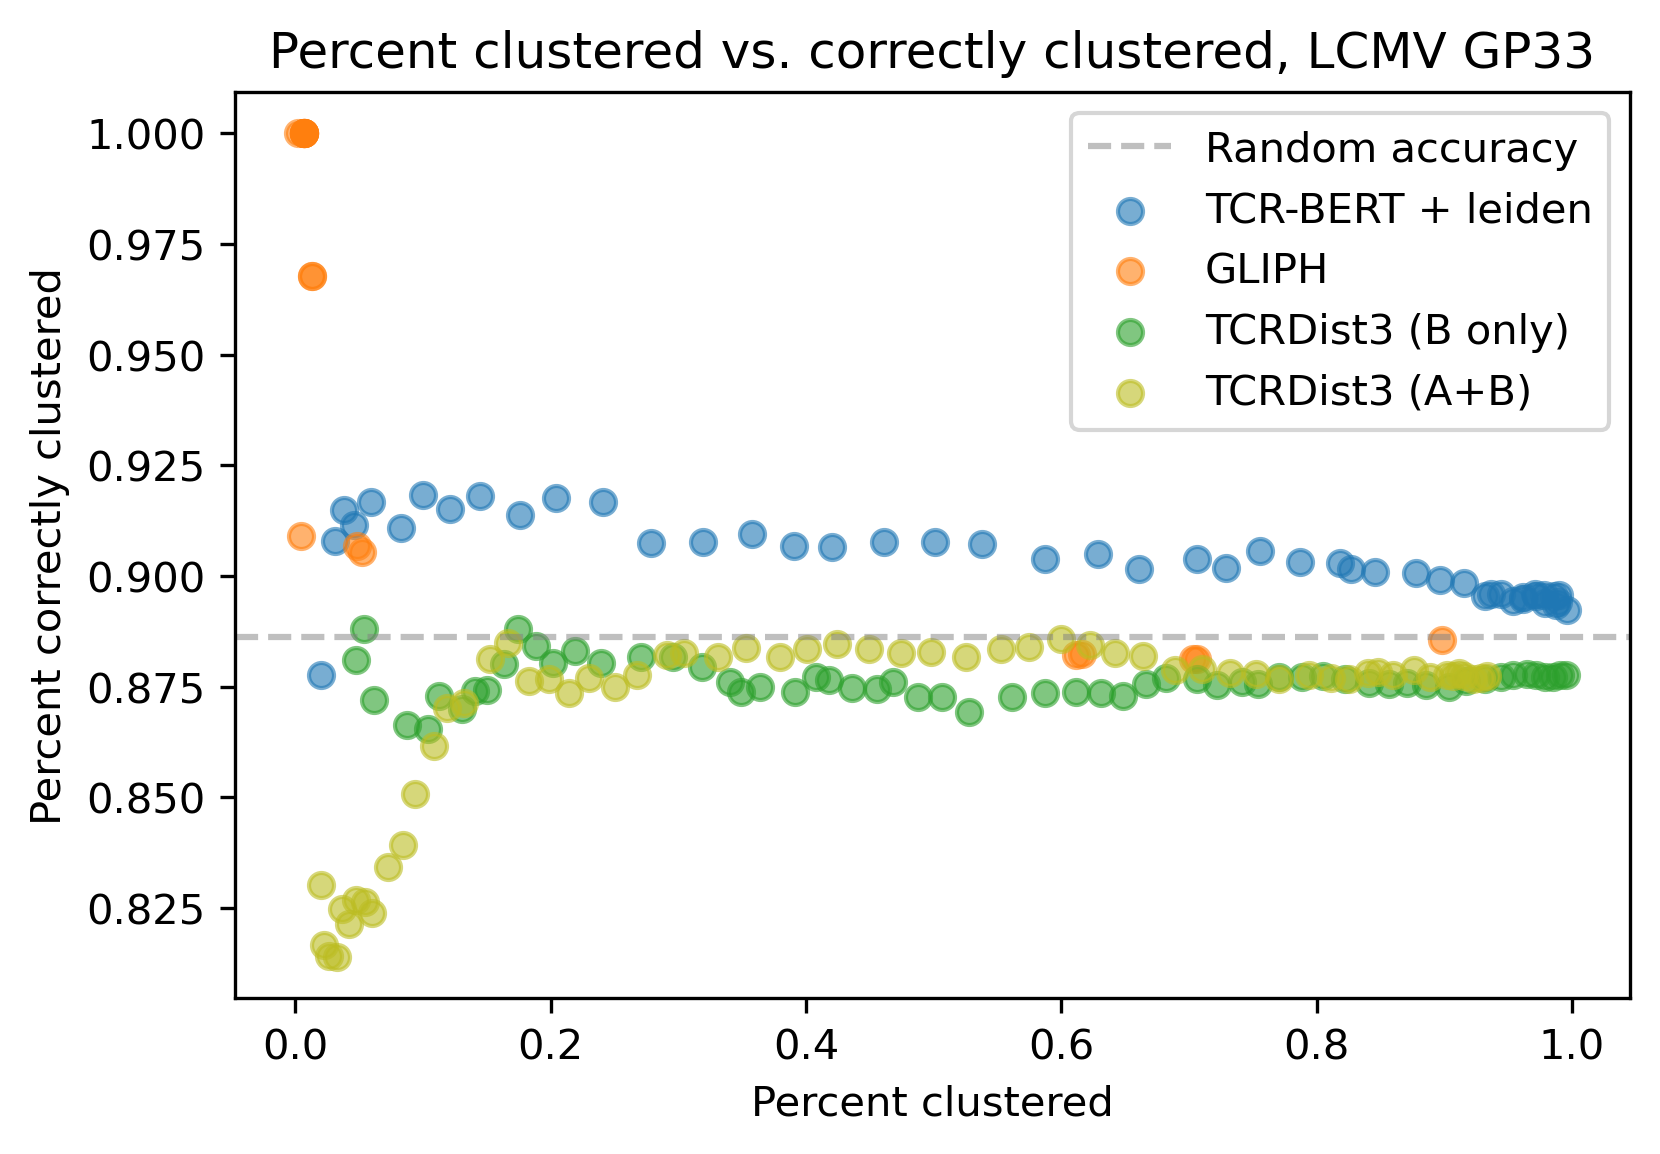

In [78]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    bert_clustering_perf_df['perc_clustered'], bert_clustering_perf_df['perc_correct'],
    alpha=0.6, label="TCR-BERT + leiden", color='tab:blue'
)
ax.scatter(
    gliph_clustering_perf_df['perc_clustered'], gliph_clustering_perf_df['perc_correct'],
    alpha=0.6, label='GLIPH', color='tab:orange',
)
# ax.scatter(
#     bert_dual_clustering_perf_df['perc_clustered'], bert_dual_clustering_perf_df['perc_correct'],
#     alpha=0.6, label='TCR-BERT TRA+TRB, leiden', color='tab:green',
# )
ax.scatter(
    tcrdist3_cluster_perf['perc_clustered'], tcrdist3_cluster_perf['perc_correct'],
    alpha=0.6, label="TCRDist3 (B only)", color="tab:green",
)
ax.scatter(
    tcrdist3_dual_cluster_perf['perc_clustered'], tcrdist3_dual_cluster_perf['perc_correct'],
    alpha=0.6, label="TCRDist3 (A+B)", color='tab:olive',
)
ax.axhline(
    1.0 - np.mean(list(lcmv_labels_sub_dict.values())),
    color='grey',
    alpha=0.5,
    linestyle='--',
    label='Random accuracy',
)

ax.legend()
ax.set(
    xlabel="Percent clustered",
    ylabel="Percent correctly clustered",
    title="Percent clustered vs. correctly clustered, LCMV GP33"
)
fig.savefig(os.path.join(PLOT_DIR, "lcmv_gliph_vs_bert.pdf"), bbox_inches='tight')
fig.show()

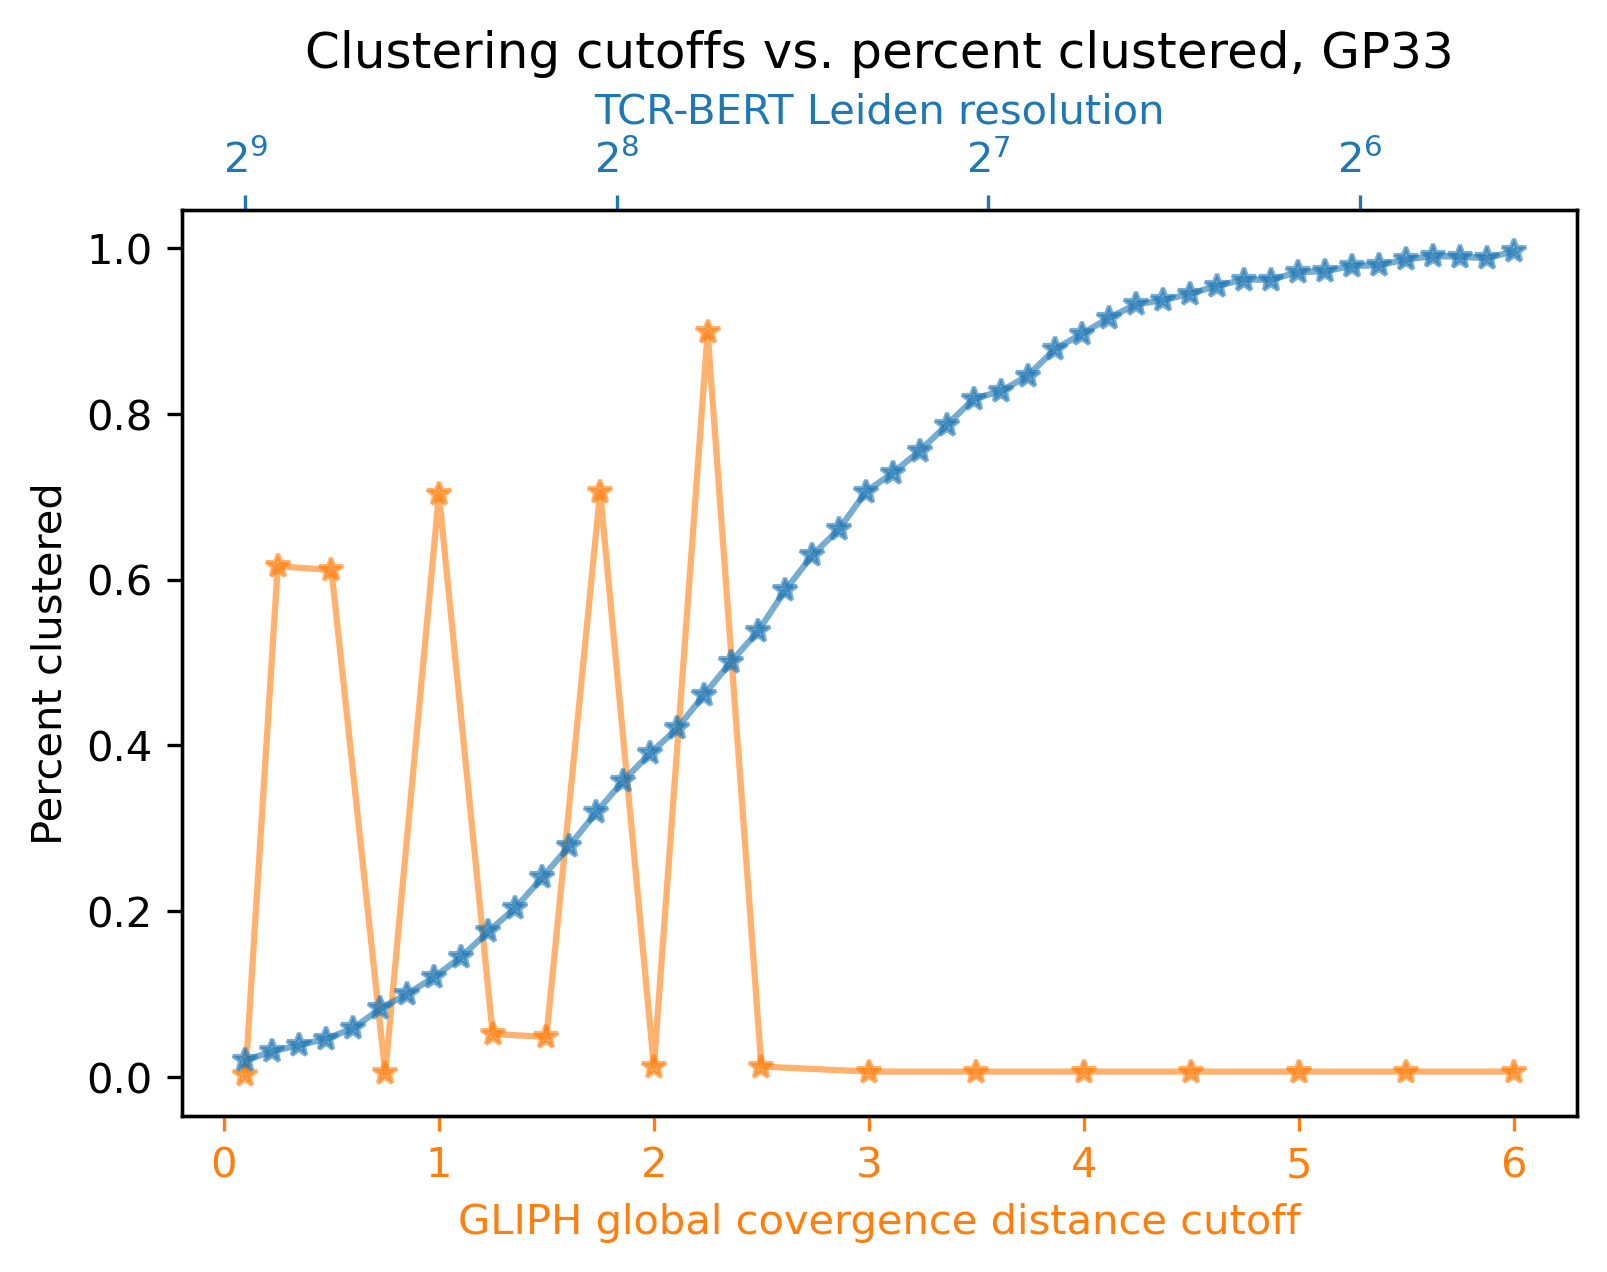

In [79]:
importlib.reload(plot_utils)
plot_utils.plot_perf_over_params(
    {"GLIPH": gliph_clustering_perf_df}, {"TCR-BERT": bert_clustering_perf_df}, 'perc_clustered',
    title="Clustering cutoffs vs. percent clustered, GP33",
    fname=os.path.join(PLOT_DIR, "lcmv_gliph_vs_bert_perc_clustered.pdf"),
).show()

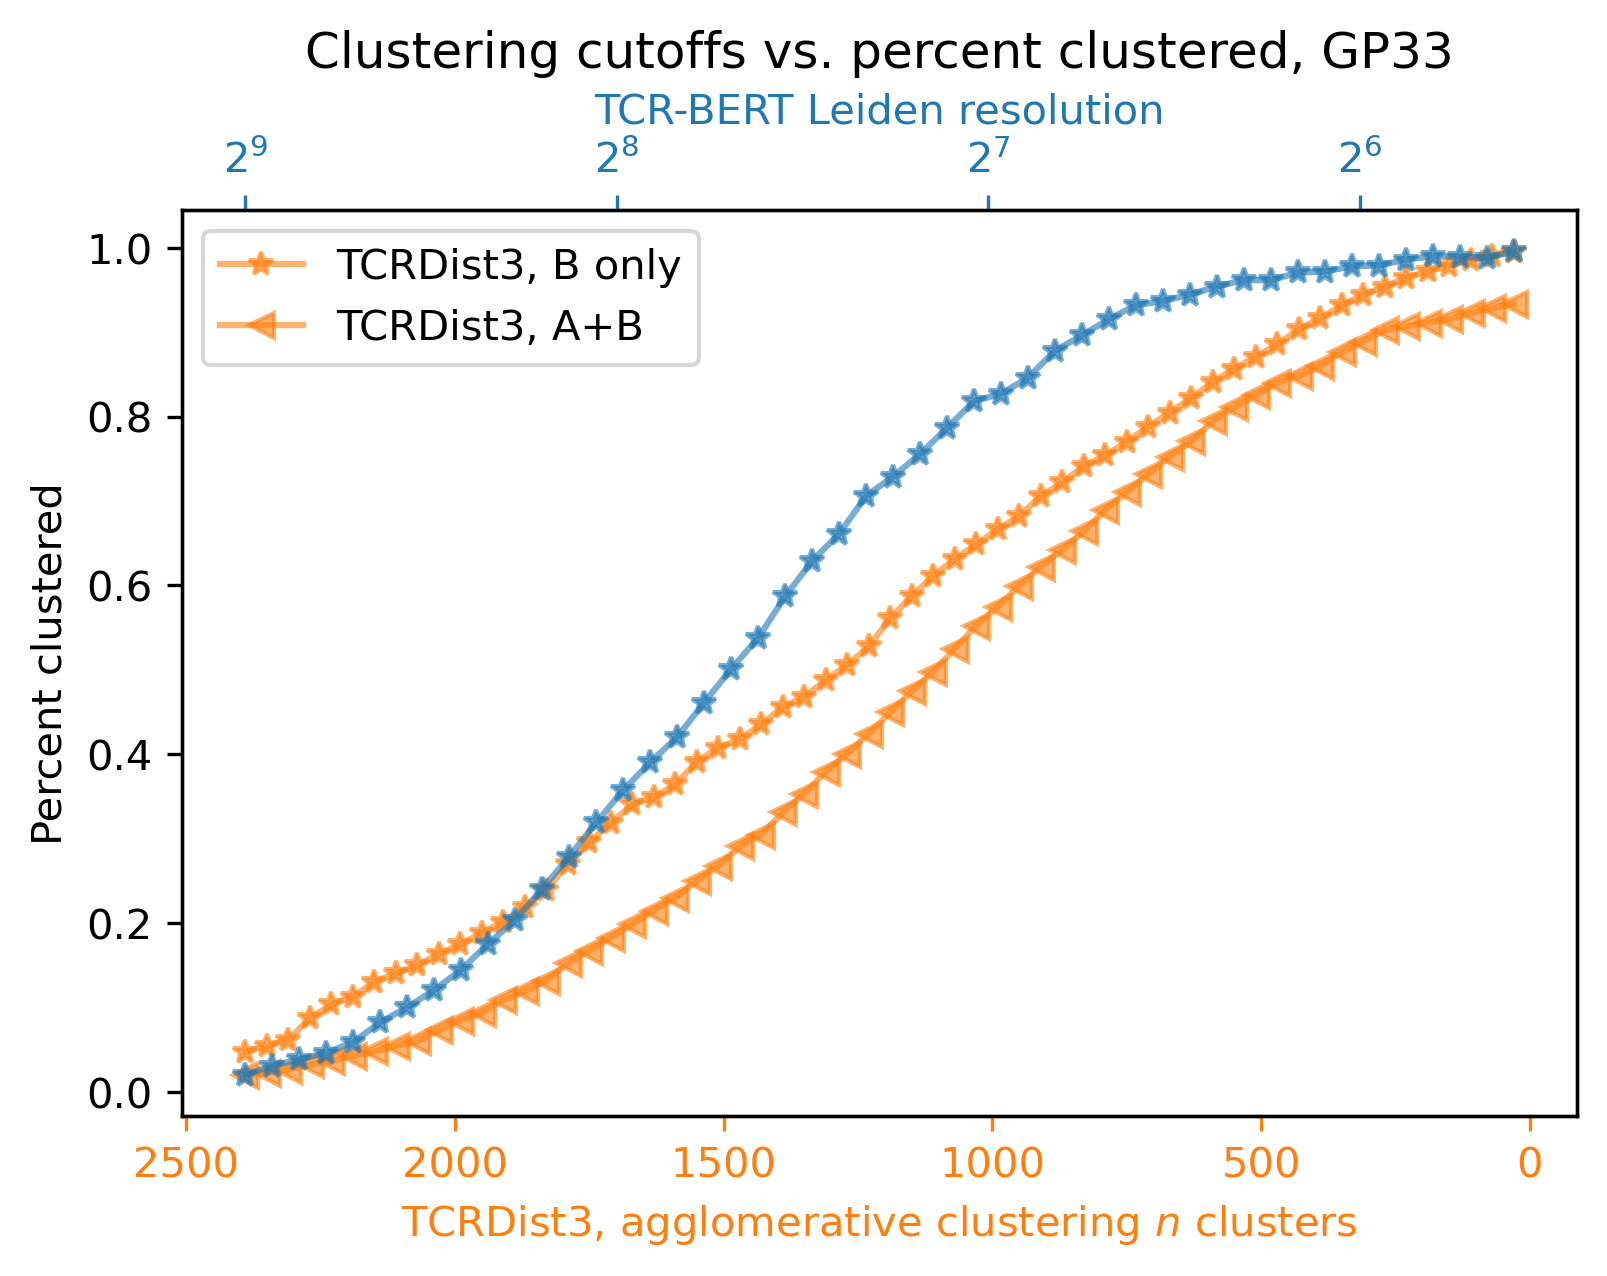

In [80]:
importlib.reload(plot_utils)
plot_utils.plot_perf_over_params(
    {"TCRDist3, B only": tcrdist3_cluster_perf, "TCRDist3, A+B": tcrdist3_dual_cluster_perf}, {"TCR-BERT": bert_clustering_perf_df}, 'perc_clustered',
    bot_reverse=True,
    bot_label="TCRDist3, agglomerative clustering $n$ clusters",
    title="Clustering cutoffs vs. percent clustered, GP33",
    fname=os.path.join(PLOT_DIR, "lcmv_tcrdist3_vs_bert_perc_clustered.pdf"),
).show()

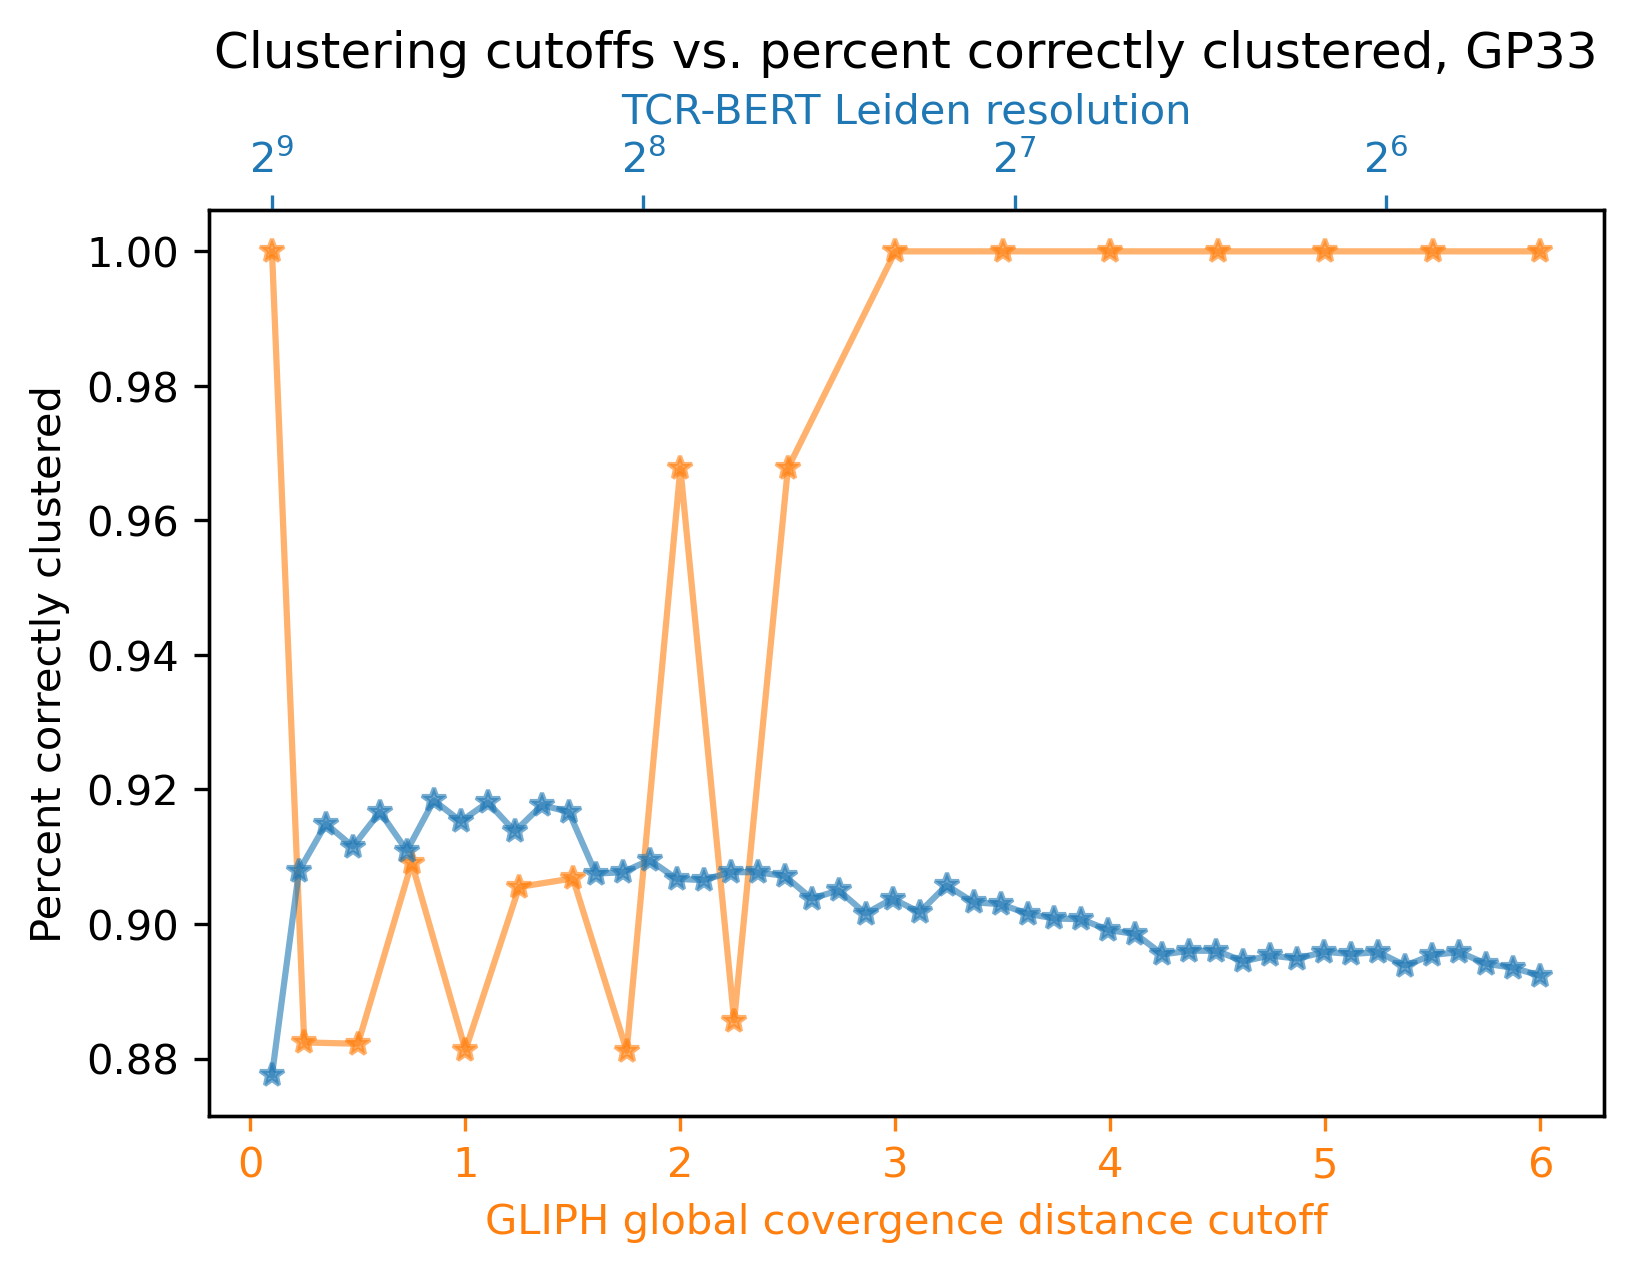

In [81]:
importlib.reload(plot_utils)
plot_utils.plot_perf_over_params(
    {"GLIPH": gliph_clustering_perf_df}, {"TCR-BERT": bert_clustering_perf_df}, 'perc_correct',
    title="Clustering cutoffs vs. percent correctly clustered, GP33",
    fname=os.path.join(PLOT_DIR, "lcmv_gliph_vs_bert_perc_correct.pdf"),
).show()

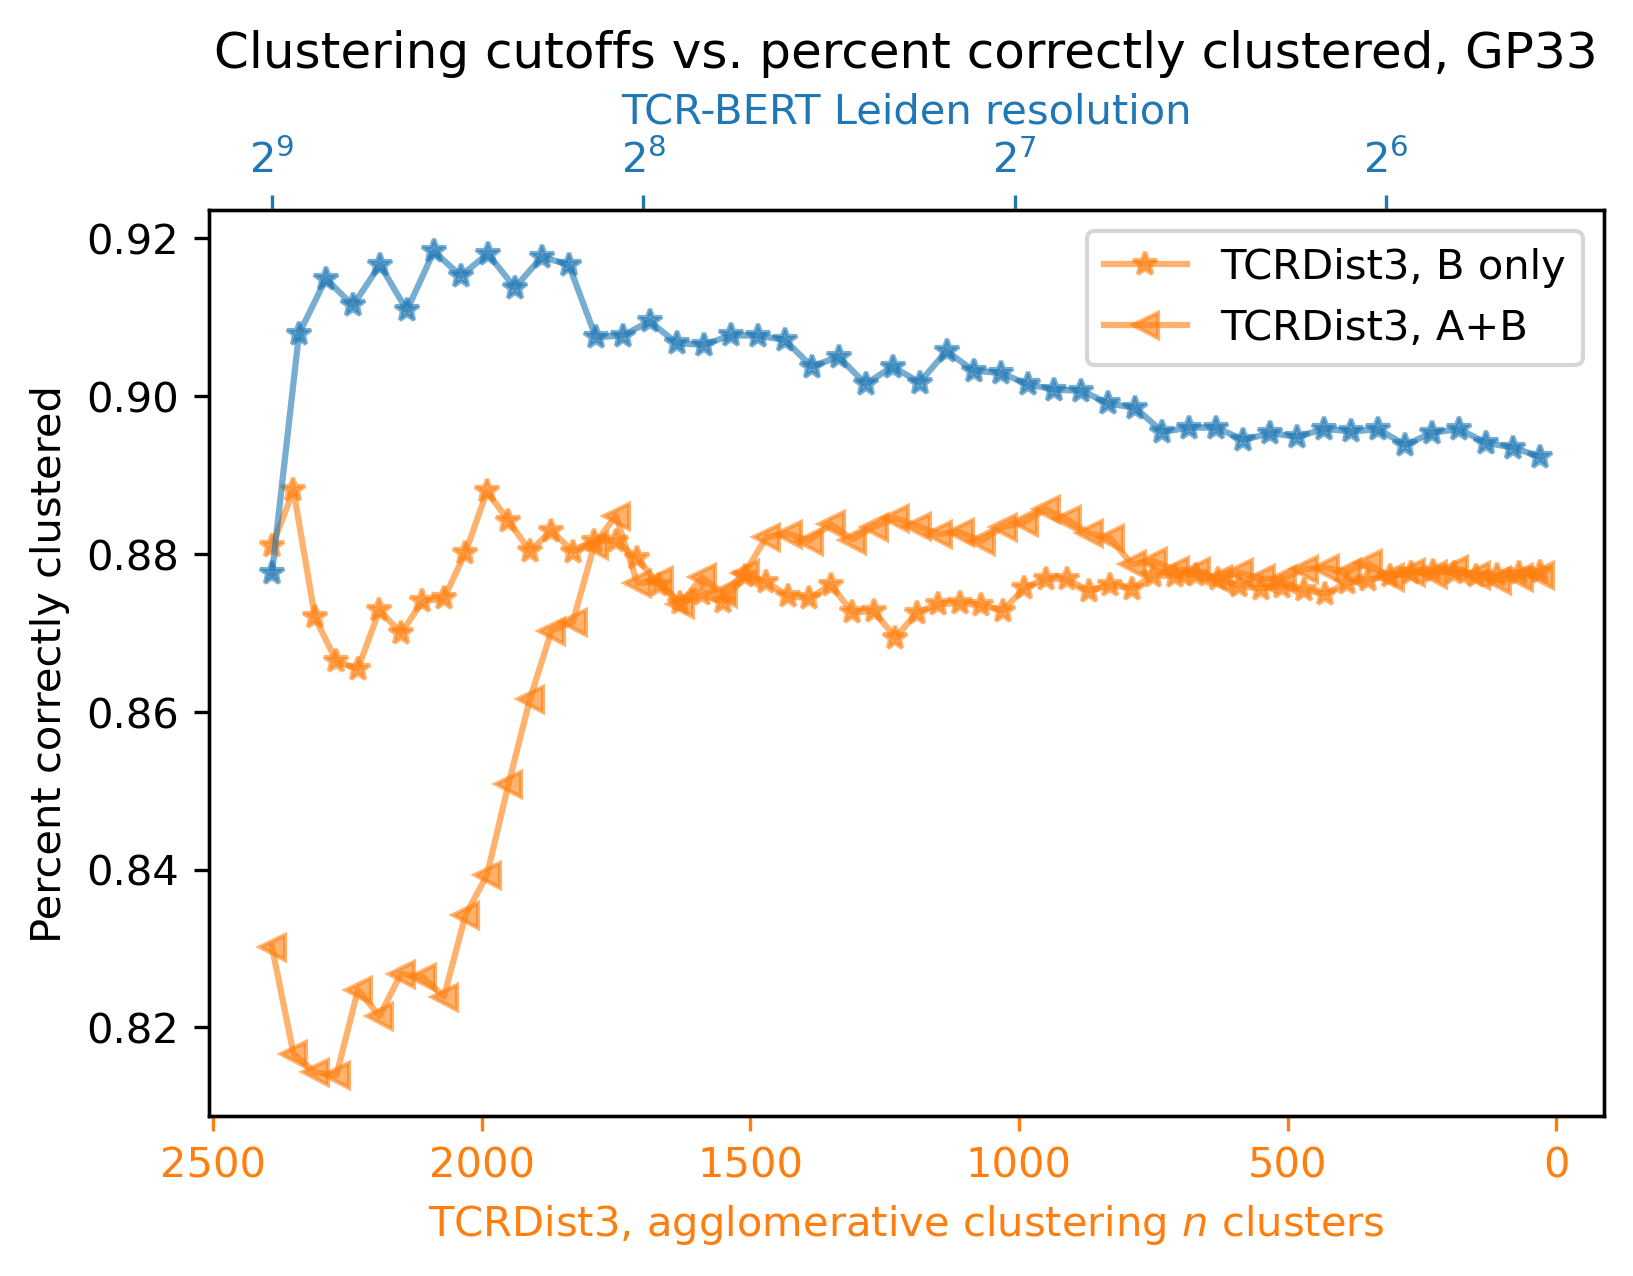

In [82]:
importlib.reload(plot_utils)
plot_utils.plot_perf_over_params(
    {"TCRDist3, B only": tcrdist3_cluster_perf, "TCRDist3, A+B": tcrdist3_dual_cluster_perf}, {"TCR-BERT": bert_clustering_perf_df}, 'perc_correct',
    bot_reverse=True,
    bot_label="TCRDist3, agglomerative clustering $n$ clusters",
    title="Clustering cutoffs vs. percent correctly clustered, GP33",
    fname=os.path.join(PLOT_DIR, "lcmv_tcrdist3_vs_bert_perc_correct.pdf"),
).show()